In [1]:
%config InlineBackend.figure_format='retina'

import os
from functools import reduce
from glob import glob
from itertools import chain
from operator import and_
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib; matplotlib.rc('text', usetex=True); matplotlib.rc('font', size=14)
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.coordinates import SkyCoord
from scipy import interpolate, ndimage, stats

from calibration.data import get_passband, castelli_kurucz_locus, calamida_lco_t2
from calibration.syn_mag import syn_mag

In [2]:
BANDS = 'ugrizY'

def bandname(band):
    return f'CTIO/DECam.{band}'

In [3]:
reddening = {band: get_passband(bandname(band)).meta['A_AV'] for band in BANDS}
reddening

{'u': 1.49, 'g': 1.2, 'r': 0.842, 'i': 0.636, 'z': 0.495, 'Y': 0.436}

In [4]:
tonry_locus = pd.read_csv('tonry_ps1_locus.txt', sep='\s+')
tonry_locus

,ri,gr,iz,zy
0,-0.4,-0.50,-0.290,-0.210
1,-0.2,-0.19,-0.110,-0.050
2,0.0,0.15,-0.030,-0.025
3,0.2,0.55,0.090,0.035
4,0.4,0.97,0.200,0.095
5,0.6,1.16,0.295,0.140
6,1.0,1.20,0.470,0.195
7,2.0,1.26,0.940,0.470


In [5]:
ck_locus_mags = {}
METALLICITY_MARKERS = {
    # -1.5: 'v',
    0.0: 'd',
    # 0.5: '^',
}
for metallicity in METALLICITY_MARKERS:
    seds = castelli_kurucz_locus(metallicity)
    mags = {band: np.array([syn_mag(sed, bandname(band)) for sed in seds]) for band in BANDS}
    ck_locus_mags[metallicity] = mags

In [6]:
dawd_names = sorted(os.path.basename(fname.removesuffix('.csv')) for fname in glob('des_1deg_cone/*.csv'))
dawd_magn = {}
for band in BANDS:
    dawd_magn[band] = []
    dawd_magn_name = []
    for name in dawd_names:
        try:
            dawd_magn[band].append(syn_mag(name, bandname(band)))
        except KeyError:  # some spectra are missed
            print(f'{name} is missed')
        else:
            dawd_magn_name.append(name)
    assert len(set(dawd_magn_name)) == len(dawd_magn_name)
    if 'name' in dawd_magn:
        assert np.all(np.array(dawd_magn_name) == dawd_magn['name'])
    else:
        dawd_magn['name'] = np.array(dawd_magn_name)
    dawd_magn[band] = np.array(dawd_magn[band])
    print(band)
    pprint(dict(zip(dawd_magn_name, dawd_magn[band])))

WDFS0122-30 is missed
WDFS0238-36 is missed
WDFS0458-56 is missed
WDFS0541-19 is missed
WDFS0639-57 is missed
WDFS0956-38 is missed
WDFS1055-36 is missed
WDFS1206-27 is missed
WDFS1434-28 is missed
WDFS1535-77 is missed
WDFS1837-70 is missed
WDFS1930-52 is missed
WDFS2037-05 is missed
WDFS2317-29 is missed
u
{'WDFS0103-00': 18.758383176995462,
 'WDFS0228-08': 19.833212285304963,
 'WDFS0248+33': 18.201991746020035,
 'WDFS0727+32': 17.691083680842844,
 'WDFS0815+07': 19.46918271323213,
 'WDFS1024-00': 18.689533496453485,
 'WDFS1110-17': 17.56623514466264,
 'WDFS1111+39': 18.065932067451328,
 'WDFS1206+02': 18.627970350427972,
 'WDFS1214+45': 17.497545981485057,
 'WDFS1302+10': 16.741766169993877,
 'WDFS1314-03': 18.804141743708712,
 'WDFS1514+00': 15.559503421309289,
 'WDFS1557+55': 17.11881662388203,
 'WDFS1638+00': 18.53007460866487,
 'WDFS1814+78': 16.323807383018675,
 'WDFS2101-05': 18.506217759880652,
 'WDFS2329+00': 18.2048285111783,
 'WDFS2351+37': 17.84734668667394}
WDFS0122-30 i

In [7]:
df = pd.concat([pd.read_csv(fname, index_col='coadd_object_id', engine='pyarrow')
                for fname in sorted(glob('des_1deg_cone/*.csv'))])
# assert df.shape[0] == len(set(df.index)), f'{df.shape[0]} {len(set(df.index))}'
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7677585 entries, 1035999977 to 1186568897
Columns: 229 entries, alphawin_j2000 to tilename
dtypes: float64(193), object(36)
memory usage: 13.2+ GB


In [8]:
df.head(20)[[column for column in df.columns if 'auto' in column]]

,fluxerr_auto_g,fluxerr_auto_i,fluxerr_auto_r,fluxerr_auto_y,fluxerr_auto_z,flux_auto_g,flux_auto_i,flux_auto_r,flux_auto_y,flux_auto_z,...,mag_auto_g,mag_auto_g_dered,mag_auto_i,mag_auto_i_dered,mag_auto_r,mag_auto_r_dered,mag_auto_y,mag_auto_y_dered,mag_auto_z,mag_auto_z_dered
coadd_object_id,,,,,,,,,,,,,,,,,,,,,
1035999977,17.587194,44.592518,26.067741,261.74506,76.774180,15.199088,194.622760,60.38021,222.445280,442.657700,...,27.045456,26.916677,24.277016,24.213596,25.547764,25.461266,24.131943,24.089582,23.384830,23.336489
1035998192,25.960905,65.470190,36.573555,346.02664,106.919390,136.887990,1369.778700,449.74026,1784.795900,1988.885500,...,24.659086,24.525720,22.158375,22.092697,23.367596,23.278015,21.871029,21.827160,21.753475,21.703411
1035998116,14.639234,38.160990,20.622805,195.34402,60.222496,32.333027,146.115000,103.15873,-12.903098,162.309510,...,26.225883,26.092453,24.588263,24.522552,24.966234,24.876612,99.000000,99.000000,24.474140,24.424051
1035998106,23.180910,55.259070,32.491300,307.32180,94.844860,348.303440,524.001460,353.40347,406.840030,588.659000,...,23.645105,23.511868,23.201670,23.136055,23.629322,23.539827,23.476440,23.432613,23.075340,23.025324
1035997936,32.058950,76.374794,44.841850,444.09260,130.846500,239.822680,2996.797600,1181.39300,4834.499000,4181.999000,...,24.050274,23.916780,21.308357,21.242617,22.319014,22.229347,20.789122,20.745210,20.946540,20.896430
1035999034,34.710495,85.301290,50.310165,505.49800,148.174040,353.643250,754.327300,553.09880,1552.630600,1083.601400,...,23.628586,23.497194,22.806100,22.741396,23.142994,23.054740,22.022330,21.979110,22.412827,22.363504
1035999028,56.207657,138.566250,81.779076,821.81510,240.917470,521.287960,837.776000,850.10565,698.985600,1374.567400,...,23.207306,23.076075,22.692180,22.627554,22.676317,22.588171,22.888830,22.845663,22.154585,22.105322
1035999171,24.879614,61.864254,36.623400,366.57294,107.430650,511.914760,1066.063000,891.41990,1513.054700,1256.742900,...,23.227005,23.096060,22.430542,22.366056,22.624794,22.536840,22.050364,22.007290,22.251884,22.202728
1035998126,25.976543,61.836640,36.077248,349.87290,106.703780,168.619600,94.133180,183.12730,371.141900,166.794460,...,24.432730,24.298632,25.065643,24.999603,24.343117,24.253044,23.576150,23.532040,24.444546,24.394207


In [9]:
# ps1_mean = pd.read_csv('results/ps1/mean.csv', index_col='objID')
# ps1_dawd = pd.merge(df, ps1_mean[['name']], on='objID', how='inner')
# ps1_dawd['name'] = ps1_dawd['name'].str.replace('-', '')
# ps1_dawd_no_dups = ps1_dawd.drop_duplicates(ignore_index=False, subset=['name'])
# ps1_dawd_no_dups.to_csv('ps1_stacked.csv')
# ps1_dawd

ri — gr : 63401 / 7677585
ri — iz : 80563 / 7677585
ri — zY : 41853 / 7677585


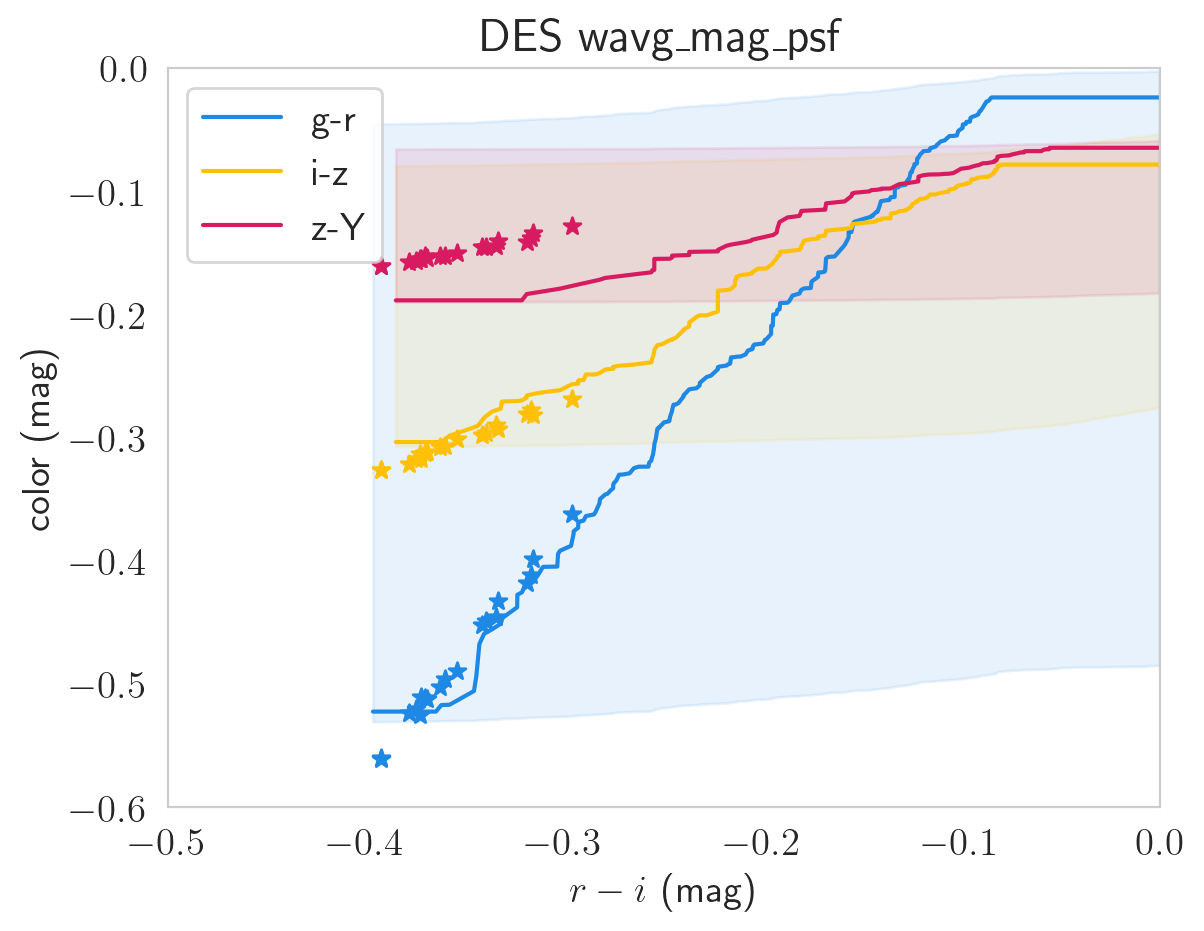

In [14]:
COLORS = ['#D81B60', '#1E88E5', '#FFC107']
BAND_COLORS = {
    'u': '#0072B2',
    'g': '#56B4E9',
    'r': '#009E73',
    'i': '#E69F00',
    'z': '#D55E00',
    'y': '#CC79A7',
}


# flag 1 means aperture photometry is affected
for mag_type, magerr_type, max_flags in [
    # ('mag_auto', 'magerr_auto', 0),
    ('wavg_mag_psf', 'wavg_magerr_psf', 1)
]:
    def average_filter(input, size, mode):
        return ndimage.generic_filter(input, np.mean, size=size, mode=mode)

    def std_filter(input, size, mode):
        return ndimage.generic_filter(input, np.std, size=size, mode=mode, extra_keywords=dict(ddof=1))

    def plot_color(cx, cy, *, color, yarrow, xarrow=1.6, xlim=(-np.inf, np.inf), ylim=(-np.inf, np.inf)):
        mag = [df[f'{mag_type}_{band.lower()}'] for band in chain(cx, cy)]
        magerr = [df[f'{magerr_type}_{band.lower()}'] for band in chain(cx, cy)]
        flags = [df[f'flags_{band.lower()}'] for band in chain(cx, cy)]
        class_star = [df[f'class_star_{band.lower()}'] for band in chain(cx, cy)]
        spread_model = [df[f'spread_model_{band.lower()}'] for band in chain(cx, cy)]
        good = reduce(and_, chain.from_iterable([
            (m > 15.0 for m in mag),
            (m < 26.0 for m in mag),
            (merr < 0.02 for merr in magerr),
            (f <= max_flags for f in flags),
            # (cs > 0.9 for cs in class_star),
            (sm < 0.01 for sm in spread_model),
            [df['ebv_sfd98'] < 0.02],
        ]))
        # good = np.ones(df.shape[0], dtype=bool)
        print(f'{cx} — {cy} : {np.sum(good)} / {df.shape[0]}')

        x = mag[0][good] - mag[1][good]
        y = mag[2][good] - mag[3][good]

        # _, uniq_idx = np.unique(np.stack([x, y], axis=-1), return_index=True, axis=0)
        # n_max = 10_000
        # uniq_idx = np.random.default_rng(0).choice(uniq_idx, min(n_max, len(uniq_idx)), replace=False)

        # # Plot all points
        # plt.scatter(x.to_numpy()[uniq_idx], y.to_numpy()[uniq_idx], s=0.1, alpha=0.01, color=color)

        # # Plot contour
        # sns.kdeplot(
        #     x=x.to_numpy()[uniq_idx],
        #     y=y.to_numpy()[uniq_idx],
        #     fill=True,
        #     cbar=False,
        #     cmap='magma_r',
        #     # levels=30,
        #     # thresh=0.0,
        #     levels=[0.01, 0.02, 0.03, 0.04, 0.05, 0.075, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        #     bw_adjust=3,
        #     # alpha=0.2,
        #     # color=color,
        #     # levels=[0.1, 0.2, 0.4, 0.6, 0.8],
        # )

        # Plot distribution
        filter_size = 3000

        idx_sort_x = np.argsort(x)
        x = x.iloc[idx_sort_x]
        y = y.iloc[idx_sort_x]

        idx = (x > xlim[0]) & (x < xlim[1]) & (y > ylim[0]) & (y < ylim[1])
        x = x[idx]
        y = y[idx]

        y_mean = average_filter(y, size=filter_size, mode='nearest')
        y_std = std_filter(y, size=filter_size, mode='nearest')
        y_median = ndimage.median_filter(y, size=filter_size, mode='nearest')
        y_10 = ndimage.percentile_filter(y, 10, size=filter_size, mode='nearest')
        y_90 = ndimage.percentile_filter(y, 90, size=filter_size, mode='nearest')

        # Plot stats
        plt.plot(x, y_median, color=color, label=f'{cy[0]}-{cy[1]}')
        plt.fill_between(x, y_mean - y_std, y_mean + y_std, color=color, alpha=0.1)

        # Plot Tonry locus
        # x_ = np.linspace(tonry_locus[cx].min(), tonry_locus[cx].max(), 101)
        # spl = interpolate.UnivariateSpline(x=tonry_locus[cx], y=tonry_locus[cy], k=1, s=0)
        # plt.plot(x_, spl(x_), lw=1, ls='--', color='black')
        # plt.scatter(tonry_locus[cx], tonry_locus[cy], s=100, marker='s', color=color, edgecolor='black')

        # Plot Castelli-Kurucz locus
        # for metallicity, ck_mags in ck_locus_mags.items():
        #     ck_x = ck_mags[cx[0]] - ck_mags[cx[1]]
        #     ck_y = ck_mags[cy[0]] - ck_mags[cy[1]]
        #
        #     ck_idx = np.argsort(ck_x)
        #     ck_x = ck_x[ck_idx]
        #     ck_y = ck_y[ck_idx]
        #
        #     plt.scatter(ck_x, ck_y, s=40, marker=METALLICITY_MARKERS[metallicity], edgecolors=color, facecolors='none')


        # Plot synthetic DAWD
        plt.scatter(dawd_magn[cx[0]] - dawd_magn[cx[1]], dawd_magn[cy[0]] - dawd_magn[cy[1]],
                    s=40, marker='*', color=color)
        # for x_coord_, y_coord_, name_ in zip(dawd_magn[cx[0]] - dawd_magn[cx[1]],
        #                                      dawd_magn[cy[0]] - dawd_magn[cy[1]],
        #                                      dawd_magn_name):
            # plt.text(x=x_coord_,
            #          y=y_coord_,
            #          s=f'{name_}syn',
            #          size=1)

        # Plot real DAWD
        # x_coord = ps1_dawd_no_dups[f'{cx[0]}{mag_type}Mag'] - ps1_dawd_no_dups[f'{cx[1]}{mag_type}Mag']
        # y_coord = ps1_dawd_no_dups[f'{cy[0]}{mag_type}Mag'] - ps1_dawd_no_dups[f'{cy[1]}{mag_type}Mag']
        # plt.scatter(x_coord,
        #             y_coord,
        #             s=10, marker='P', color=color)
        # plt.errorbar(x=x_coord,
        #              y=y_coord,
        #              xerr=np.linalg.norm([ps1_dawd_no_dups[f'{cx[0]}{mag_type}MagErr'], ps1_dawd_no_dups[f'{cx[1]}{mag_type}MagErr']], axis=0),
        #              yerr=np.linalg.norm([ps1_dawd_no_dups[f'{cy[0]}{mag_type}MagErr'], ps1_dawd_no_dups[f'{cy[1]}{mag_type}MagErr']], axis=0),
        #              color=color, ls='')
        # for x_coord_, y_coord_, name_ in zip(x_coord, y_coord, ps1_dawd_no_dups['name']):
            # plt.text(x=x_coord_,
            #          y=y_coord_,
            #          s=f'{name_}real',
            #          size=1)

        # Plot reddening vectors
        plt.arrow(xarrow, yarrow, reddening[cx[0]] - reddening[cx[1]], reddening[cy[0]] - reddening[cy[1]],
                  color=color, length_includes_head=True, width=0.01)

    def plot_residuals(c_, xrange=np.arange(16, 22)):
        offset_step = np.ptp(xrange) + 1
        for i, c in enumerate(c_):
            offset = offset_step * i
            for name, syn_magn in zip(dawd_magn['name'], dawd_magn[c]):
                try:
                    ps1_row = ps1_dawd[ps1_dawd['name'].str.lower() == name].iloc[0]
                except IndexError:
                    continue
                res = ps1_row[f'{c}{mag_type}Mag'] - syn_magn
                ps1_magerr = ps1_row[f'{c}{mag_type}MagErr']
                plt.plot(syn_magn + offset, res, 'o', color=BAND_COLORS[c])
                plt.errorbar(syn_magn + offset, res, ps1_magerr, color=BAND_COLORS[c])
                plt.text(syn_magn + offset, res, name, color=BAND_COLORS[c], size=4)
        base_ticks = np.arange(16, 16 + offset_step)
        ticks = np.tile(base_ticks, len(c_)) + np.repeat(np.arange(len(c_)) * offset_step, base_ticks.size)
        tick_labels = np.tile(base_ticks, len(c_)).astype(str)
        print(ticks)
        print(tick_labels)
        colors = np.repeat([BAND_COLORS[c] for c in c_], base_ticks.size)
        plt.xticks(ticks, tick_labels)
        for color, t in zip(colors, plt.gca().xaxis.get_ticklabels()):
            t.set_color(color)

    def plot_res_distrs(c_):
        fig, ax_ = plt.subplots(1, len(c_), sharey=True, figsize=(2.6*len(c_), 3))
        for ax, c in zip(ax_, c_):
            res_ = []
            err_ = []
            for name, syn_magn in zip(dawd_magn['name'], dawd_magn[c]):
                try:
                    ps1_row = ps1_dawd[ps1_dawd['name'].str.lower() == name].iloc[0]
                except IndexError:
                    continue
                res = ps1_row[f'{c}{mag_type}Mag'] - syn_magn
                ps1_magerr = ps1_row[f'{c}{mag_type}MagErr']
                res_.append(res)
                err_.append(ps1_magerr)
            res_ = np.array(res_)
            err_ = np.array(err_)
            redused_chi2 = np.sum(np.square(res_ / err_)) / (res_.size - 1)
            print(f'{c} {redused_chi2 = :.2f}')
            scaled_err_ = err_ * np.sqrt(redused_chi2)
            x_ = np.linspace(-1.0, 1.0, 1001)
            distr_ = stats.norm.pdf(x_, res_[:,None], scaled_err_[:,None])
            for distr in distr_:
                ax.plot(x_ * 1000, distr, '--', color='grey', alpha=0.3, lw=1.5)
            avg_distr = np.mean(distr_, axis=0)
            mu = np.mean(x_ * avg_distr)
            sigma = np.sqrt(np.mean(np.square(x_ - mu) * avg_distr))
            ax.plot(x_ * 1000, avg_distr, color=BAND_COLORS[c], lw=3,
                    label=rf'''{{\bf PS1 $\Delta {c}$}}
$\mu = {mu*1e3:.2f}$
$\mathrm{{RMS}} = {sigma*1e3:.1f}$''')
            ax.set_xlabel(fr'$\Delta {c}$ (mmag)')
            ax.set_xlim([-140, 140])
            for spine in ax.spines.values():
                spine.set_color('black')
            ax.grid(True)
            ax.legend(loc='upper right')
        ax_[0].set_ylabel(r'$P(\Delta)$')
        ax_[0].set_ylim([0.0, None])
        fig.subplots_adjust(hspace=0, wspace=0, right=0.85)
        fig.tight_layout()


    # plt.figure(figsize=(15, 9))
    # plot_residuals('griz')
    # plt.grid()
    # plt.savefig(f'{mag_type}_res.pdf')

    # plot_res_distrs('griz')
    # plt.savefig(f'{mag_type}_res_distr.pdf', dpi=600)

    plt.figure()
    plt.title(f'DES {mag_type}')
    plt.xlabel('$r-i$ (mag)')
    plt.ylabel('color (mag)')
    # plot_color('ri', 'gr', color=COLORS[1], xlim=[-0.5, 1.5], ylim=[-1.0, 1.5], yarrow=1.1)
    # plot_color('ri', 'iz', color=COLORS[2], xlim=[-0.5, 1.5], ylim=[-0.5, 0.8], yarrow=0.6)
    # plot_color('ri', 'zY', color=COLORS[0], xlim=[-0.5, 1.5], ylim=[-0.5, 0.5], yarrow=0.2)
    plot_color('ri', 'gr', color=COLORS[1], xlim=[-0.5, 0.0], ylim=[-1.0, 0.0], yarrow=1.1)
    plot_color('ri', 'iz', color=COLORS[2], xlim=[-0.5, 0.0], ylim=[-0.5, 0.0], yarrow=0.6)
    plot_color('ri', 'zY', color=COLORS[0], xlim=[-0.5, 0.0], ylim=[-0.5, 0.0], yarrow=0.2)
    # 2d histogram
    # Figure 22 Narayan 2019
    #
    plt.xlim([-0.5, 0.0])
    plt.ylim([-0.6, 0.0])
    # plt.xlim([-0.5, None])
    # plt.ylim([-0.5, None])
    plt.legend(loc='upper left')
    plt.grid()
    plt.savefig(f'{mag_type}.pdf', dpi=600)